# For ECCO

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.99:42969")
client

Client Scheduler: tcp://10.32.5.99:42969 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 27 Cores: 54 Memory: 310.50 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

# Validating Heat Budget (w zarr ds)

In [3]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_th.zarr'))
ds

<xarray.Dataset>
Dimensions:                  (i: 360, j: 270, k: 50, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>

In [4]:
ds_surf = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_surf_th.zarr'))
ds_surf

<xarray.Dataset>
Dimensions:               (i: 360, j: 270, k: 18, time: 288)
Coordinates:
  * time                  (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    surface_flux_conv_TH  (time, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    sw_flux_conv_TH       (time, j, i, k) float32 dask.array<chunksize=(1, 90, 90, 17), meta=np.ndarray>

### Entire WG column budget

In [5]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [7]:
ds_wg = ds.isel(**lat_range, **lon_range)
ds_wg_surf = ds_surf.isel(**lat_range, **lon_range)

In [8]:
horiz = (ds_wg.conv_horiz_diff_flux_TH +
         ds_wg.conv_horiz_adv_flux_TH).sum(dim=['i', 'j', 'k'])
surf = (ds_wg_surf.sw_flux_conv_TH.sum(dim=['i', 'j', 'k']) +
        ds_wg_surf.surface_flux_conv_TH.sum(dim=['i', 'j']))

rhs_heat = (horiz + surf).load()

In [9]:
lhs_heat = ds_wg.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


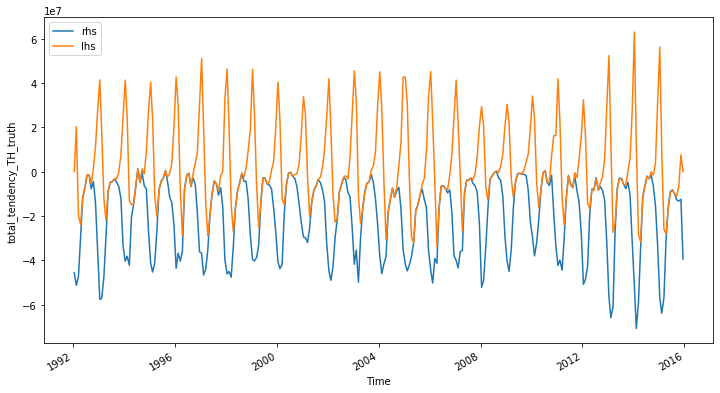

In [10]:
plt.figure(figsize=(12,6))
rhs_heat.plot(label='rhs')
lhs_heat.plot(label='lhs')
plt.legend();

### Interior WG column budget

In [11]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167

lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [12]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [13]:
ds_wg_lower = ds.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_wg_lower

<xarray.Dataset>
Dimensions:                  (i: 92, j: 40, k: 13, time: 288)
Coordinates:
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    theta                    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>

In [14]:
rhs_heat_lower = ((ds_wg_lower.conv_horiz_adv_flux_TH + 
                  ds_wg_lower.conv_horiz_diff_flux_TH + 
                  ds_wg_lower.conv_vert_adv_flux_TH +
                  ds_wg_lower.conv_vert_diff_flux_TH).sum(dim=['i', 'j', 'k'])).load()

lhs_heat_lower = ds_wg_lower.total_tendency_TH_truth.sum(dim=['i', 'j', 'k']).load()

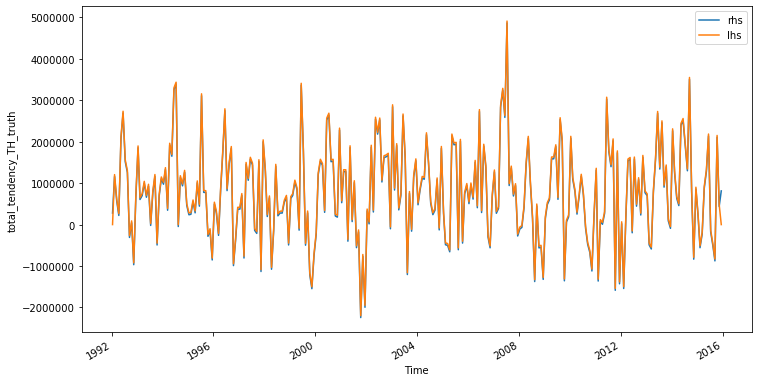

In [15]:
plt.figure(figsize=(12,6))
rhs_heat_lower.plot(label='rhs')
lhs_heat_lower.plot(label='lhs')
plt.legend();

# Validating Salt Budget (w zarr ds)

In [16]:
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/budget_slt.zarr'))
ds_slt

<xarray.Dataset>
Dimensions:                   (i: 360, j: 270, k: 50, time: 288, time_snp: 287)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 270, 360), meta=np.ndarray>
    salt

### Entire WG column budget

In [17]:
ds_slt_wg = ds_slt.isel(**lat_range, **lon_range)
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (i: 92, j: 40, k: 50, time: 288, time_snp: 287)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 50, 40, 92), meta=np.ndarray>
    salt_snp          

In [18]:
rhs_slt = ((ds_slt_wg.conv_horiz_adv_flux_SLT +
            ds_slt_wg.conv_horiz_diff_flux_SLT +
            ds_slt_wg.salt_plume).sum(dim=['i', 'j', 'k']) +
            ds_slt_wg.surface_flux_SLT.sum(dim=['i', 'j'])).load()

lhs_slt = ds_slt_wg.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

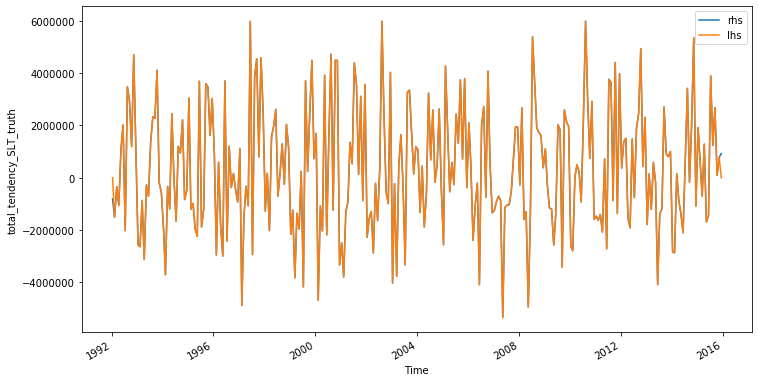

In [19]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend();

### Interior WG column budget

In [29]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167

lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [30]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [35]:
ds_slt_wg_lower = ds_slt.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_slt_wg_lower

<xarray.Dataset>
Dimensions:                   (i: 92, j: 40, k: 13, time: 288, time_snp: 287)
Coordinates:
  * time                      (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                  (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
Dimensions without coordinates: i, j, k
Data variables:
    conv_horiz_adv_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt                      (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt_plume                (time, k, j, i) float32 dask.array<chunksize=(1, 13, 40, 92), meta=np.ndarray>
    salt_snp          

In [36]:
rhs_slt_lower = (ds_slt_wg_lower.conv_horiz_adv_flux_SLT +
                 ds_slt_wg_lower.conv_horiz_diff_flux_SLT +
                 ds_slt_wg_lower.conv_vert_adv_flux_SLT +
                 ds_slt_wg_lower.conv_vert_diff_flux_SLT + 
                 ds_slt_wg_lower.salt_plume).sum(dim=['i', 'j', 'k']).load()

lhs_slt_lower = ds_slt_wg_lower.total_tendency_SLT_truth.sum(dim=['i', 'j', 'k']).load()

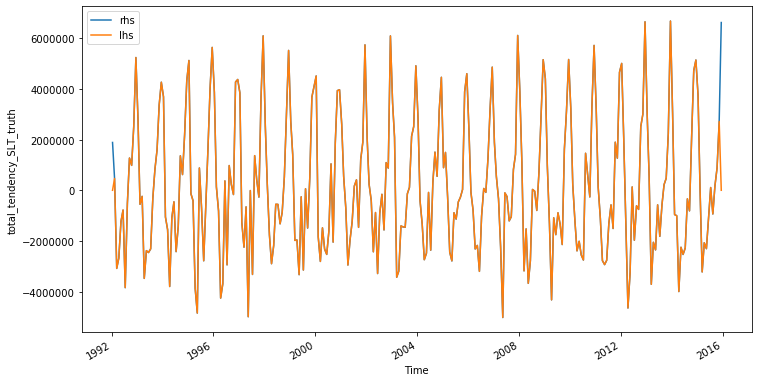

In [37]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend();